13. Sales Forecasting
- Description: Predict future sales using time series data. Implement ARIMA or Prophet models and evaluate using Mean Absolute Percentage Error (MAPE) and RMSE.

https://www.kaggle.com/datasets/tanayatipre/store-sales-forecasting-dataset

In [1]:
from google.colab import files # For uploading files
uploaded = files.upload()

Saving stores_sales_forecasting.csv to stores_sales_forecasting.csv


In [50]:
#Imported Libraries
import pandas as pd
import numpy as np
import io
from prophet import Prophet
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

In [9]:
#read csv
df = pd.read_csv(io.StringIO(uploaded['stores_sales_forecasting.csv'].decode('ISO-8859-1')))
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,4,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
3,6,CA-2014-115812,6/9/2014,6/14/2014,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,FUR-FU-10001487,Furniture,Furnishings,Eldon Expressions Wood and Plastic Desk Access...,48.8600,7,0.00,14.1694
4,11,CA-2014-115812,6/9/2014,6/14/2014,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,FUR-TA-10001539,Furniture,Tables,Chromcraft Rectangular Conference Tables,1706.1840,9,0.20,85.3092


In [11]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2121 entries, 0 to 2120
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         2121 non-null   int64  
 1   Order ID       2121 non-null   object 
 2   Order Date     2121 non-null   object 
 3   Ship Date      2121 non-null   object 
 4   Ship Mode      2121 non-null   object 
 5   Customer ID    2121 non-null   object 
 6   Customer Name  2121 non-null   object 
 7   Segment        2121 non-null   object 
 8   Country        2121 non-null   object 
 9   City           2121 non-null   object 
 10  State          2121 non-null   object 
 11  Postal Code    2121 non-null   int64  
 12  Region         2121 non-null   object 
 13  Product ID     2121 non-null   object 
 14  Category       2121 non-null   object 
 15  Sub-Category   2121 non-null   object 
 16  Product Name   2121 non-null   object 
 17  Sales          2121 non-null   float64
 18  Quantity

,Row ID,Postal Code,Sales,Quantity,Discount,Profit
count,2121.000000,2121.000000,2121.000000,2121.000000,2121.000000,2121.000000
mean,5041.643564,55726.556341,349.834887,3.785007,0.173923,8.699327
std,2885.740258,32261.888225,503.179145,2.251620,0.181547,136.049246
min,1.000000,1040.000000,1.892000,1.000000,0.000000,-1862.312400
25%,2568.000000,22801.000000,47.040000,2.000000,0.000000,-12.849000
50%,5145.000000,60505.000000,182.220000,3.000000,0.200000,7.774800
75%,7534.000000,90032.000000,435.168000,5.000000,0.300000,33.726600
max,9991.000000,99301.000000,4416.174000,14.000000,0.700000,1013.127000


In [26]:
#Convert 'Order Date' to datetime
df['Order Date'] = pd.to_datetime(df['Order Date'])
weekly_sales = df.resample('W-MON', on='Order Date')['Sales'].sum().reset_index()
weekly_sales.columns = ['ds', 'y']
#Check for missing dates and fill with 0 sales
all_dates = pd.date_range(start=weekly_sales['ds'].min(), end=weekly_sales['ds'].max())
weekly_sales = weekly_sales.set_index('ds').reindex(all_dates).fillna(0.0).rename_axis('ds').reset_index()

print(weekly_sales.head())

          ds        y
0 2014-01-06  2573.82
1 2014-01-07     0.00
2 2014-01-08     0.00
3 2014-01-09     0.00
4 2014-01-10     0.00


In [32]:
#train and test split
train = weekly_sales[:-12]
test = weekly_sales[-12:]

In [46]:
# Initialize and fit model
model = Prophet(weekly_seasonality=True, yearly_seasonality=True)
model.add_country_holidays(country_name='US')
model.fit(train)

# Forecast future values (same length as test set)
future = model.make_future_dataframe(periods=90)
forecast = model.predict(future)

# Extract only the forecasted values that match the test set
forecast_test = forecast[['ds', 'yhat']].set_index('ds').loc[test['ds']].reset_index()

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmph64t660n/10lmm3vp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmph64t660n/lhng5lsg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59828', 'data', 'file=/tmp/tmph64t660n/10lmm3vp.json', 'init=/tmp/tmph64t660n/lhng5lsg.json', 'output', 'file=/tmp/tmph64t660n/prophet_models_lv3wbn/prophet_model-20250721011305.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:13:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:13:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [47]:
#evaluation
y_true = test['y'].values
y_pred = forecast_test['yhat'].values

mape = mean_absolute_percentage_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

filtered_mape = mean_absolute_percentage_error(y_true[y_true != 0], y_pred[y_true != 0])
print(f"Filtered MAPE: {filtered_mape:.2%}")

print(f"MAPE: {mape:.2%}")
print(f"RMSE: {rmse:.2f}")

Filtered MAPE: 40.70%
MAPE: 40.70%
RMSE: 3808.79


In [48]:
print("Number of zeros in actual test values:", np.sum(y_true == 0))
print("Mean Daily Sales (Test):", np.mean(y_true))
print("Median Daily Sales (Test):", np.median(y_true))

Number of zeros in actual test values: 0
Mean Daily Sales (Test): 6986.29075
Median Daily Sales (Test): 6251.3356


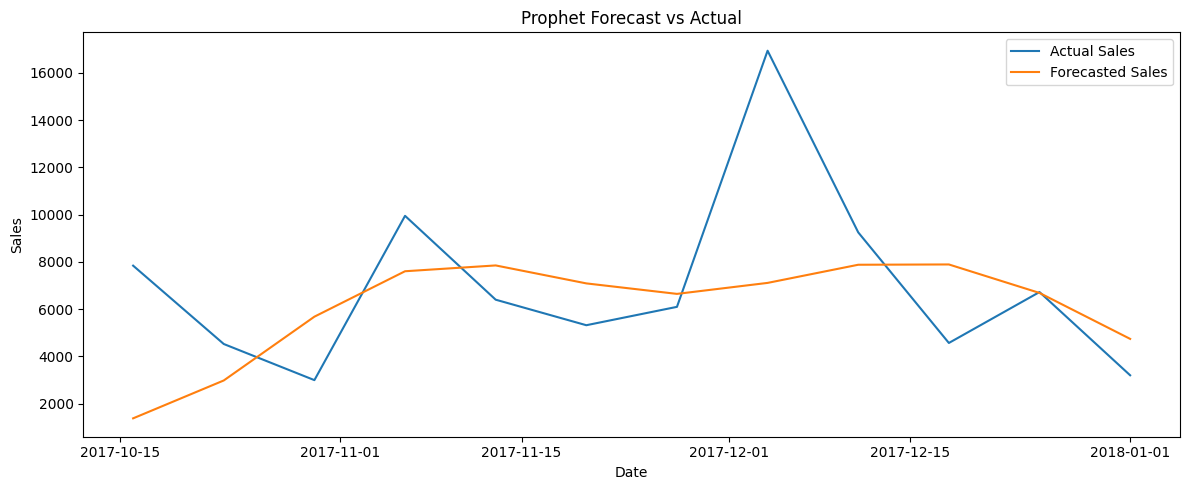

In [49]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(test['ds'], y_true, label='Actual Sales')
plt.plot(test['ds'], y_pred, label='Forecasted Sales')
plt.title('Prophet Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.tight_layout()
plt.show()